In [ ]:
# Fix SSL warnings and setup environment
import warnings
import urllib3
import ssl
import os

# Suppress SSL warnings
warnings.filterwarnings('ignore', category=urllib3.exceptions.NotOpenSSLWarning)
warnings.filterwarnings('ignore', message='urllib3 v2 only supports OpenSSL 1.1.1+')

# Additional SSL configuration for macOS
os.environ['PYTHONHTTPSVERIFY'] = '0'
os.environ['CURL_CA_BUNDLE'] = ''

# Suppress other common warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

print("SSL warnings suppressed")
print("Environment configured for medical image processing")


Install required dependencies

In [ ]:
pip install -r requirements.txt

Helper functions 

In [43]:
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os


def load_csv_data(csv_file_path):
    """
    Loads CSV dataset into a pandas DataFrame.
    Returns the DataFrame if successful, None otherwise.
    """
    print("Loading CSV dataset...")
    try:
        df = pd.read_csv(csv_file_path)
        print(f"CSV loaded successfully from: {csv_file_path}")
        return df
    except FileNotFoundError:
        print(f"Error: Could not find file {csv_file_path}")
        return None
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None
    
def plot_class_label_images(df):
    # Get unique labels
    unique_labels = df['label'].unique()

    # Create a figure with subplots for each label
    fig, axes = plt.subplots(1, len(unique_labels), figsize=(15, 5))

    # For each label, display one sample image
    for idx, label in enumerate(unique_labels):
        # Get first image for this label
        sample_row = df[df['label'] == label].iloc[0]
        img_path = os.path.join('data', label, sample_row['file_name'])
        
        # Load and display image
        img = Image.open(img_path)
        axes[idx].imshow(img, cmap='gray') 
        axes[idx].set_title(f'Class: {label}')
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()
    

Initial analysis of data available in metadata.csv. Provide a indicator of class balance, both visually and as a ratio. Show sample images of all of the classes.
It is assumed the dataset contains the correct column names and there is no missing data based on the Data Card provided by Kaggle.

Loading CSV dataset...
CSV loaded successfully from: data/metadata.csv

1.1 Dataset Structure:
Total samples: 21165 x-ray images
Initial feature count: 6

1.2 Class Distribution Analysis:

Class Distribution:
+-----------------+----------------+-------+
| Class           |   No of Images | %     |
+=================+================+=======+
| Normal          |          10192 | 48.2% |
+-----------------+----------------+-------+
| Lung_Opacity    |           6012 | 28.4% |
+-----------------+----------------+-------+
| COVID           |           3616 | 17.1% |
+-----------------+----------------+-------+
| Viral Pneumonia |           1345 | 6.4%  |
+-----------------+----------------+-------+
Class imbalance ratio: 7.6:1

Binary Distribution:
+-----------+----------------+-------+
| Class     |   No of Images | %     |
+===========+================+=======+
| Non-COVID |          17549 | 82.9% |
+-----------+----------------+-------+
| COVID     |           3616 | 17.1% |
+----------

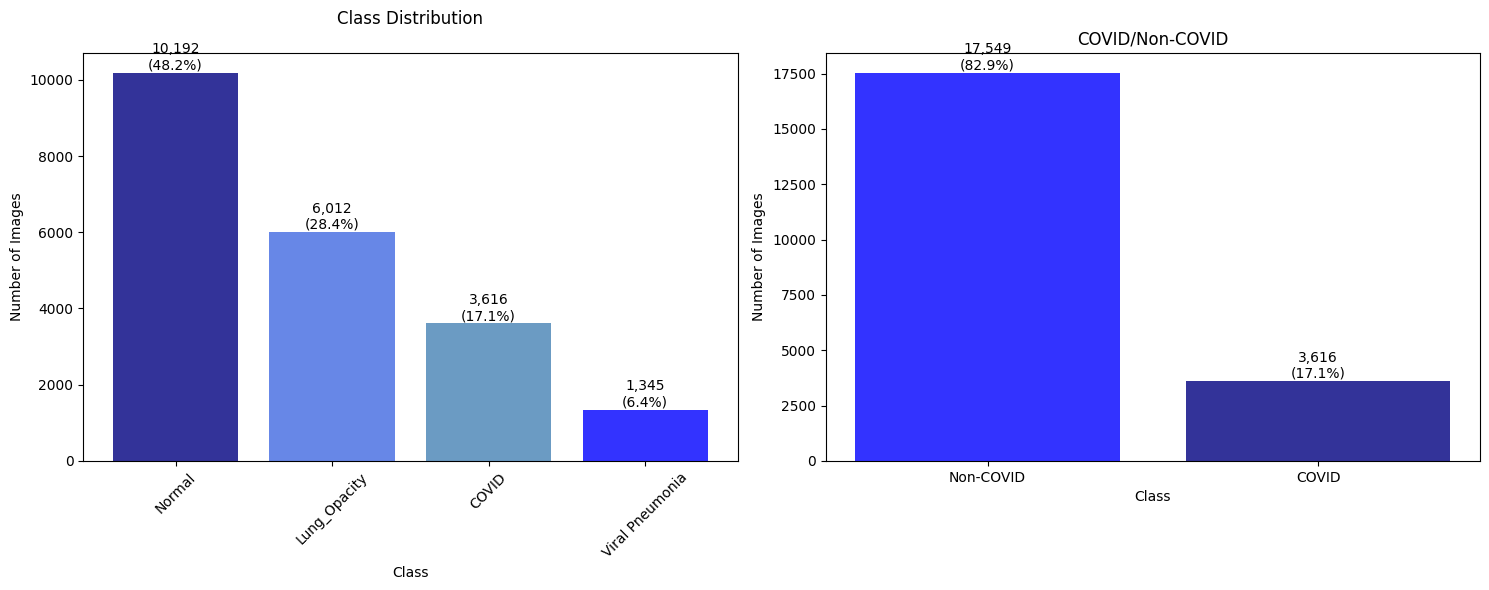


1.3 Sample Images by class:


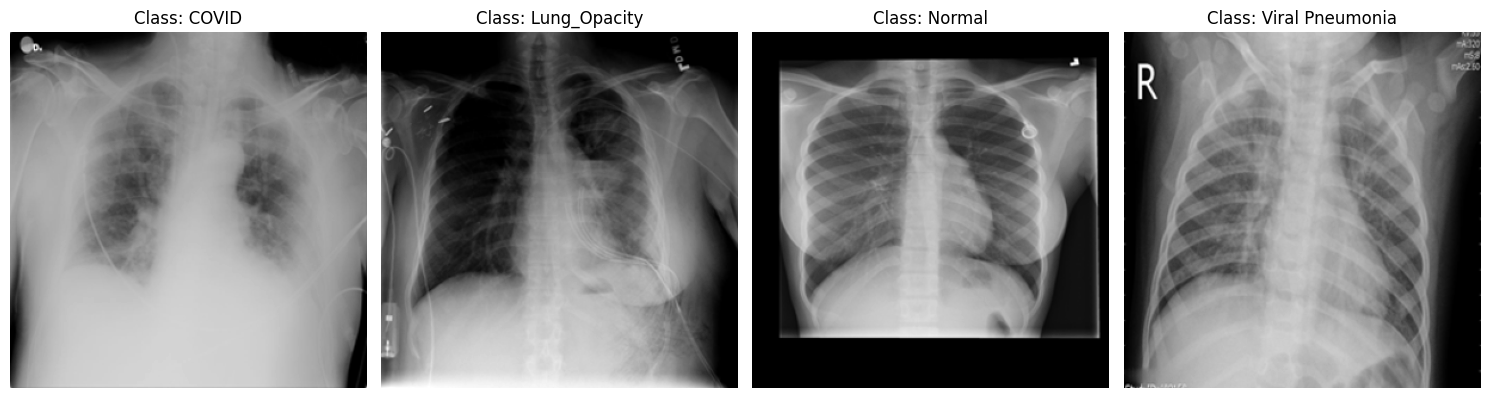

In [49]:
import random
from tabulate import tabulate

csv_path = "data/metadata.csv"
df = load_csv_data(csv_path)

# 1.1 Dataset size and structure
print(f"\n1.1 Dataset Structure:")
print(f"Total samples: {len(df)} x-ray images")
print(f"Initial feature count: {len(df.columns)}")

# 1.2 Analysis with and without Lung_Opacity
print(f"\n1.2 Class Distribution Analysis:")
if 'label' in df.columns:

    df_filtered = df.copy()
    
    # Class distribution
    print("\nClass Distribution:")
    label_counts = df['label'].value_counts()
    total = len(df)
    
    distribution_data = {
        'Class': label_counts.index,
        'No of Images': label_counts.values,
        '%': (label_counts.values / total) * 100
    }
    distribution_df = pd.DataFrame(distribution_data)
    distribution_df['%'] = distribution_df['%'].map('{:.1f}%'.format)
    print(tabulate(distribution_df, headers='keys', tablefmt='grid', showindex=False))
    
    # Compare class imbalance ratios
    imbalance_ratio = label_counts.max() / label_counts.min()
    print(f"Class imbalance ratio: {imbalance_ratio:.1f}:1")
    

    print("\nBinary Distribution:")
    df['binary_label'] = (df['label'] == 'COVID').map({True: 'COVID', False: 'Non-COVID'})
    binary_counts = df['binary_label'].value_counts()
    binary_ratio = binary_counts.max() / binary_counts.min()
    
    binary_distribution = {
        'Class': binary_counts.index,
        'No of Images': binary_counts.values,
        '%': (binary_counts.values / total) * 100
    }
    binary_df = pd.DataFrame(binary_distribution)
    binary_df['%'] = binary_df['%'].map('{:.1f}%'.format)
    print(tabulate(binary_df, headers='keys', tablefmt='grid', showindex=False))
    print(f"Non-COVID/COVID ratio: {binary_ratio:.1f}:1")
    
    # Plot distributions side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    color_palette = ['navy', 'blue', 'royalblue', 'steelblue']
    colors1 = random.sample(color_palette , min(len(label_counts), len(color_palette )))
    bars1 = ax1.bar(label_counts.index, label_counts.values, color=colors1, alpha=0.8)
    ax1.set_title('Class Distribution\n')
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.tick_params(axis='x', rotation=45)
    
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}\n({height/total*100:.1f}%)',
                ha='center', va='bottom')
    
    colors2 = random.sample(color_palette , min(len(binary_counts), len(color_palette)))
    bars2 = ax2.bar(binary_counts.index, binary_counts.values, color=colors2, alpha=0.8)
    ax2.set_title('COVID/Non-COVID')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Number of Images')
    
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,}\n({height/total*100:.1f}%)',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


# 1.3 Sample images
print("\n1.3 Sample Images by class:")
plot_class_label_images(df_filtered)

Image preprocessing. As the data provided is image_data_grayscale is a string and truncated in the metadata CSV file each image will need to be converted to a numpy array. Each image will then need to be resized and normalised to allow a model to be trained by MobileNetV2. This model was chosen due limited resources available esp. when utilising the CPU rather than GPU.

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import h5py


def create_training_data(csv_path, image_dir, output_h5_path='covid_19_training_data.h5'):
    """
    Create a balanced 50/50 COVID vs Non-COVID dataset

    Args:
        csv_path: Path to metadata CSV
        image_dir: Directory containing images
        output_h5_path: Output HDF5 file path

    Returns:
        None
    """
    print("Creating training data")
    print("="*60)
    
    # Load metadata
    df = pd.read_csv(csv_path)
    print(f"Dataset size: {len(df):,} images")
    
    df_filtered = df.copy()
    
    # Create binary labels
    df_filtered['binary_label'] = (df_filtered['label'] == 'COVID').astype(int)
    
    # Split COVID and Non-COVID
    covid_df = df_filtered[df_filtered['binary_label'] == 1].copy()
    non_covid_df = df_filtered[df_filtered['binary_label'] == 0].copy()
    
    print(f"Samples:")
    print(f"COVID: {len(covid_df):,}")
    print(f"Non-COVID: {len(non_covid_df):,}")
    
    # Use all COVID samples
    selected_covid = covid_df.copy()
    target_samples = len(selected_covid)
    
    print(f"\nTarget balanced dataset: {target_samples:,} COVID + {target_samples:,} Non-COVID")
    
    # Use ALL viral pneumonia images, then split remaining slots between Normal and Lung_Opacity
    normal_df = non_covid_df[non_covid_df['label'] == 'Normal']
    viral_df = non_covid_df[non_covid_df['label'] == 'Viral Pneumonia']
    lung_opacity_df = non_covid_df[non_covid_df['label'] == 'Lung_Opacity']
    
    # Use all available viral pneumonia samples
    target_viral = len(viral_df)
    remaining_slots = target_samples - target_viral
    
    # Calculate proportions for Normal vs Lung_Opacity from remaining two classes
    normal_lung_total = len(normal_df) + len(lung_opacity_df)
    normal_ratio_remaining = len(normal_df) / normal_lung_total
    
    target_normal = int(remaining_slots * normal_ratio_remaining)
    target_lung_opacity = remaining_slots - target_normal
    
    print(f"\nOptimized sampling strategy:")
    print(f"Viral Pneumonia: {target_viral:,} (ALL available - {target_viral/target_samples:.1%})")
    print(f"Normal: {target_normal:,} ({target_normal/target_samples:.1%})")
    print(f"Lung_Opacity: {target_lung_opacity:,} ({target_lung_opacity/target_samples:.1%})")
    
    # Sample from each category
    selected_viral = viral_df.copy()  # Use all viral pneumonia
    selected_normal = normal_df.sample(n=min(target_normal, len(normal_df)), random_state=42)
    selected_lung_opacity = lung_opacity_df.sample(n=min(target_lung_opacity, len(lung_opacity_df)), random_state=42)
    
    selected_non_covid = pd.concat([selected_normal, selected_viral, selected_lung_opacity])
        
    # Combine balanced dataset
    balanced_df = pd.concat([selected_covid, selected_non_covid]).reset_index(drop=True)
    
    print(f"\nFinal balanced dataset:")
    print(f"Total samples: {len(balanced_df):,}")
    print(f"COVID: {len(balanced_df[balanced_df['binary_label'] == 1]):,} (50.0%)")
    print(f"Non-COVID: {len(balanced_df[balanced_df['binary_label'] == 0]):,} (50.0%)")
    
    # Create HDF5 dataset
    print(f"\nProcessing images and creating HDF5 dataset...")
    
    processed_count = 0
    all_images = []
    all_labels = []
    
    batch_size = 500
    total_batches = (len(balanced_df) + batch_size - 1) // batch_size
    
    for batch_idx in range(total_batches):
        start_idx = batch_idx * batch_size
        end_idx = min((batch_idx + 1) * batch_size, len(balanced_df))
        batch_df = balanced_df.iloc[start_idx:end_idx]
        
        batch_images = []
        batch_labels = []
        
        print(f"Processing batch {batch_idx + 1}/{total_batches} ({len(batch_df)} images)...")
        
        for _, row in batch_df.iterrows():
            # Images are organized in subdirectories by class
            image_path = os.path.join(image_dir, row['label'], row['file_name'])
            
            if os.path.exists(image_path):
                try:
                    # Load and preprocess image
                    image = cv2.imread(image_path)
                    if image is not None:
                        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image_resized = cv2.resize(image_rgb, (224, 224), interpolation=cv2.INTER_LANCZOS4)
                        image_normalized = image_resized.astype(np.float32) / 255.0
                        
                        batch_images.append(image_normalized)
                        batch_labels.append(row['binary_label'])
                        processed_count += 1
                        
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")
                    continue
            else:
                print(f"Error processing {image_path}: File not found")
                continue
        
        if batch_images:
            all_images.extend(batch_images)
            all_labels.extend(batch_labels)
    
    # Convert to numpy arrays
    all_images = np.array(all_images)
    all_labels = np.array(all_labels)
    
    print(f"\nSaving to HDF5: {output_h5_path}")
    
    # Save to HDF5
    with h5py.File(output_h5_path, 'w') as f:
        f.create_dataset('images', data=all_images, compression='gzip', compression_opts=6)
        f.create_dataset('labels', data=all_labels, compression='gzip', compression_opts=6)
        
        # Add metadata
        f.attrs['total_samples'] = processed_count
        f.attrs['covid_samples'] = np.sum(all_labels)
        f.attrs['non_covid_samples'] = processed_count - np.sum(all_labels)
    
    # Calculate file size
    h5_file_size = os.path.getsize(output_h5_path)
    
    print(f"\nBALANCED DATASET SUMMARY:")
    print("="*50)
    print(f"Total processed: {processed_count:,}")
    
    covid_pct = np.sum(all_labels)/processed_count*100
    non_covid_pct = (processed_count - np.sum(all_labels))/processed_count*100
    print(f"COVID-19: {np.sum(all_labels):,} ({covid_pct:.1f}%)")
    print(f"Non-COVID-19: {processed_count - np.sum(all_labels):,} ({non_covid_pct:.1f}%)")
    print(f"File size: {h5_file_size/1024/1024:.1f} MB")
    print(f"Balance ratio: 1:1")

    return None

print("\nTraining data created")


# Main program
create_training_data(
    csv_path='data/metadata.csv',
    image_dir='data',  
)


In [4]:
import numpy as np
from tensorflow.keras.utils import Sequence

class HDF5DataGenerator(Sequence):
    """
    Data Generator for loading batches of data from HDF5 files.
    Inherits from keras.utils.Sequence to ensure proper multiprocessing.
    
    Attributes:
        h5_path (str): Path to HDF5 file
        indices (np.array): Array of indices to use for data loading
        batch_size (int): Number of samples per batch
        num_classes (int): Number of classes for one-hot encoding
        preprocess_fn (callable): Optional preprocessing function for images
        shuffle (bool): Whether to shuffle data after each epoch
        **kwargs: Additional arguments passed to parent Sequence class
    """
    
    def __init__(self, h5_path, indices, batch_size, num_classes, preprocess_fn=None, shuffle=True, **kwargs):
        """
        Initialize the generator.
        
        Args:
            h5_path: Path to HDF5 file containing 'images' and 'labels' datasets
            indices: Array of indices to use from the HDF5 file
            batch_size: Number of samples per batch
            num_classes: Number of classes (for one-hot encoding)
            preprocess_fn: Optional function to preprocess images (e.g., EfficientNet preprocessing)
            shuffle: Whether to shuffle indices after each epoch
        """

        super().__init__(**kwargs)
        self.h5_path = h5_path
        self.indices = np.array(indices)
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.preprocess_fn = preprocess_fn
        self.shuffle = shuffle
        
        # Initialize shuffling of indices
        self.on_epoch_end()
        
        # Get dataset size from HDF5 file
        with h5py.File(self.h5_path, 'r') as f:
            self.n = f['images'].shape[0]

    def __len__(self):
        """
        Returns:
            Number of batches per epoch
        """
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, idx):
        """
        Get a batch of data.
        Args:
            idx (int): Batch index
        Returns:
            tuple: (X, y) where X is a batch of images and y is batch of labels
        """
        # Get batch indices
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.indices))
        batch_indices = self.indices[start_idx:end_idx]
    
        # Sort indices for HDF5 (required for efficient access)
        batch_indices = np.sort(batch_indices)
    
        # Load batch data from HDF5 file
        with h5py.File(self.h5_path, 'r') as f:
            # Load images and labels for this batch
            X = f['images'][batch_indices]
            y = f['labels'][batch_indices]
    
        # Apply preprocessing if specified (e.g., EfficientNet preprocessing)
        if self.preprocess_fn is not None:
            X = self.preprocess_fn(X)
    
        # For binary classification with sigmoid output, return labels as-is (0 or 1)
        # For multi-class classification, use one-hot encoding
        if self.num_classes == 2:
            # Binary classification: return labels as float32 for binary_crossentropy
            y_formatted = y.astype(np.float32)
        else:
            # Multi-class classification: use one-hot encoding
            y_formatted = np.eye(self.num_classes)[y]
    
        return X, y_formatted

    def on_epoch_end(self):
        """
        Called at the end of every epoch.
        Shuffles indices if shuffle=True.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

Using dataset: covid_19_training_data.h5
COVID-19 X-RAY CLASSIFIER
Batch size: 8
Training samples: 5785
Validation samples: 1447

Building model...
Model parameters: 2,422,081

 Training started...
Epoch 1/10
724/724 ━━━━━━━━━━━━━━━━━━━━ 1690s 2s/step - accuracy: 0.8028 - auc: 0.8706 - loss: 0.4463 - precision: 0.8016 - recall: 0.8064 - val_accuracy: 0.8424 - val_auc: 0.9615 - val_loss: 0.3590 - val_precision: 0.7693 - val_recall: 0.9779 - learning_rate: 0.0010
Epoch 2/10
724/724 ━━━━━━━━━━━━━━━━━━━━ 4378s 6s/step - accuracy: 0.9050 - auc: 0.9681 - loss: 0.2273 - precision: 0.9002 - recall: 0.9131 - val_accuracy: 0.9143 - val_auc: 0.9724 - val_loss: 0.2106 - val_precision: 0.9031 - val_recall: 0.9281 - learning_rate: 0.0010
Epoch 3/10
724/724 ━━━━━━━━━━━━━━━━━━━━ 1685s 2s/step - accuracy: 0.9322 - auc: 0.9823 - loss: 0.1693 - precision: 0.9247 - recall: 0.9406 - val_accuracy: 0.9240 - val_auc: 0.9801 - val_loss: 0.1995 - val_precision: 0.8846 - val_recall: 0.9751 - learning_rate: 0.001

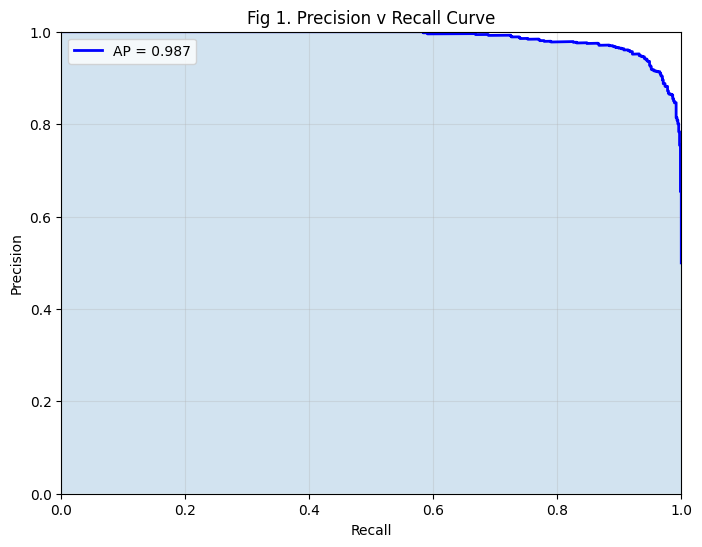

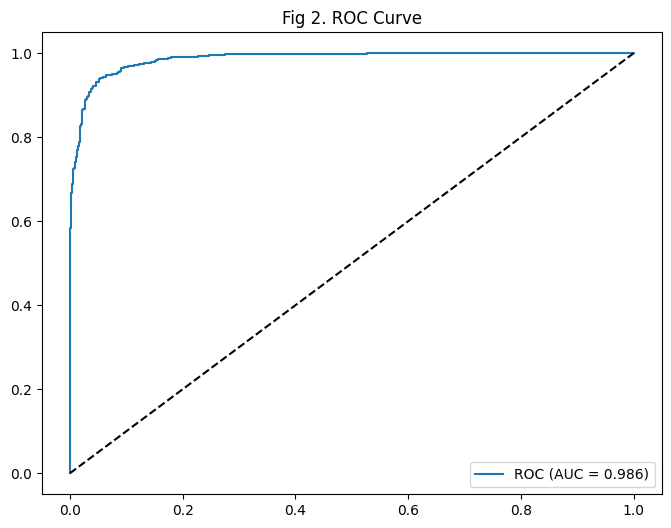


Training completed

Model saved to: covid_19_classifier_20250620_153059.keras

PERFORMANCE METRICS:
   ROC AUC:     0.9863
   Precision:   0.9493
   Recall:      0.9322
   Accuracy:    0.9413

Training completed!


In [5]:

import numpy as np
import h5py
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.metrics import (roc_curve, auc,precision_score, recall_score)

import matplotlib.pyplot as plt

def train_mobilenet(
    h5_path,
    validation_split=0.2,
    batch_size=8, 
    epochs=10,
    patience=3,
    plot_metrics=True,
):
    """
    MobileNetV2 training model
    
    Args:
        h5_path: Path to HDF5 file containing training data
        validation_split: Fraction of data to hold out for validation
        batch_size: Number of samples per batch
        epochs: Number of training epochs
        patience: Number of epochs with no improvement before early stopping
        plot_metrics: Whether to plot metrics during training

    Returns:
        model: Trained model
        history: Training history
        metrics: Dictionary of metrics
    """
    import gc
    
    print("COVID-19 X-RAY CLASSIFIER")
    print("="*60)
    print(f"Batch size: {batch_size}")
    
    try:
       
        with h5py.File(h5_path, 'r') as f:
            total_samples = f['images'].shape[0]
            all_labels = f['labels'][:]
        
        # Create train/val split indices
        indices = np.arange(total_samples)
        train_indices, val_indices = train_test_split(
            indices, test_size=validation_split, 
            random_state=42, stratify=all_labels
        )
        
        print(f"Training samples: {len(train_indices)}")
        print(f"Validation samples: {len(val_indices)}")
        
        # Create data generators
        train_generator = HDF5DataGenerator(
            h5_path=h5_path,
            indices=train_indices,
            batch_size=batch_size,
            num_classes=2,
            shuffle=True
        )
        
        val_generator = HDF5DataGenerator(
            h5_path=h5_path,
            indices=val_indices,
            batch_size=batch_size,
            num_classes=2,
            shuffle=False
        )
        
        print("\nBuilding model...")
        
        # Clear any existing models from memory
        tf.keras.backend.clear_session()
        gc.collect()
        
        base_model = MobileNetV2(
            input_shape=(224, 224, 3),
            include_top=False,
            weights='imagenet'
        )
        
        # Simpler architecture to reduce memory usage
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128, activation='relu', name='dense_1')(x)
        x = tf.keras.layers.Dropout(0.2, name='dropout_1')(x)
        predictions = Dense(1, activation='sigmoid', name='predictions')(x)
        
        model = Model(inputs=base_model.input, outputs=predictions)
        base_model.trainable = False
        
        # Compile with essential metrics only
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'precision', 'recall', 'auc']
        )
        
        print(f"Model parameters: {model.count_params():,}")
        
        # Memory-safe callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_auc',
                patience=patience,
                restore_best_weights=True,
                verbose=1,
                mode='max'
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=patience//2,
                min_lr=1e-6,
                verbose=1
            )
        ]
        
        print(f"\n Training started...")
        
 
        history = model.fit(
            train_generator,
            epochs=epochs,
            validation_data=val_generator,
            callbacks=callbacks,
            verbose=1
        )
        
        print("\nGenerating predictions...")
        val_predictions = []
        val_true_labels = []
        
        for i in range(len(val_generator)):
            batch_x, batch_y = val_generator[i]
            pred_batch = model.predict(batch_x, verbose=0)
            val_predictions.extend(pred_batch.flatten())
            # For binary classification, batch_y is already in correct format (0 or 1)
            val_true_labels.extend(batch_y.flatten())
        
        y_pred_proba = np.array(val_predictions)
        y_val = np.array(val_true_labels)
        
        # Calculate essential metrics
        y_pred = (y_pred_proba > 0.5).astype(int)
        
        accuracy = np.mean(y_pred == y_val)
        precision = precision_score(y_val, y_pred)
        recall = recall_score(y_val, y_pred)
        
        # ROC AUC
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Simple visualization if requested
        if plot_metrics:
            # Figure 1: Precision-Recall Curve
            precisions, recalls, _ = precision_recall_curve(y_val, y_pred_proba)
            ap_score = average_precision_score(y_val, y_pred_proba)
            
            plt.figure(figsize=(8, 6))
            plt.plot(recalls, precisions, 'b-', linewidth=2, label=f'AP = {ap_score:.3f}')
            plt.fill_between(recalls, precisions, alpha=0.2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Fig 1. Precision v Recall Curve')
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.show()

            # Figure 2: ROC Curve
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.title('Fig 2. ROC Curve')
            plt.legend()
            plt.show()
        
        # Clean up memory
        gc.collect()
        
        metrics_dict = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'roc_auc': roc_auc
        }
        
        print("\nTraining completed")
        return model, history, metrics_dict
        
    except Exception as e:
        print(f"\n Errors occurred during training: {str(e)}")
        
        # Clean up on error
        tf.keras.backend.clear_session()
        gc.collect()
        
        raise e


h5_file_path = 'covid_19_training_data.h5'

print(f"Using dataset: {h5_file_path}")


model, history, metrics = train_mobilenet(
    h5_path=h5_file_path,
    validation_split=0.2,
)

# Save model with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_save_path = f'covid_19_classifier_{timestamp}.keras'
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")

# Print summary of key metrics
print(f"\nPERFORMANCE METRICS:")
print(f"   ROC AUC:     {metrics['roc_auc']:.4f}")
print(f"   Precision:   {metrics['precision']:.4f}")
print(f"   Recall:      {metrics['recall']:.4f}")
print(f"   Accuracy:    {metrics['accuracy']:.4f}")

print("\nTraining completed!")